In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')  # Download stopwords for the first run
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KASHISH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data=pd.read_csv(r"C:\Users\KASHISH\Downloads\predicted_genres.csv")
%timeit data.to_parquet('predicted_genres.parquet')
%timeit data_parquet=pd.read_parquet('predicted_genres.parquet')

The slowest run took 4.41 times longer than the fastest. This could mean that an intermediate result is being cached.
744 ms ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
440 ms ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
print(data.head())

   Id                          Title  \
0   1          Edgar's Lunch (1998)    
1   2      La guerra de papá (1977)    
2   3   Off the Beaten Track (2010)    
3   4        Meu Amigo Hindu (2015)    
4   5             Er nu zhai (1955)    

                                         Description  \
0   L.R. Brane loves his life - his car, his apar...   
1   Spain, March 1964: Quico is a very naughty ch...   
2   One year in the life of Albin and his family ...   
3   His father has died, he hasn't spoken with hi...   
4   Before he was known internationally as a mart...   

                                       Text_cleaning Predicted_Genre  
0  brane loves life car apartment job especially ...          drama   
1  spain march quico naughty child three belongin...          drama   
2  one year life albin family shepherds north tra...    documentary   
3  father died hasnt spoken brother years serious...          drama   
4  known internationally martial arts superstar b...          drama

In [4]:
print(data.columns)

Index(['Id', 'Title', 'Description', 'Text_cleaning', 'Predicted_Genre'], dtype='object')


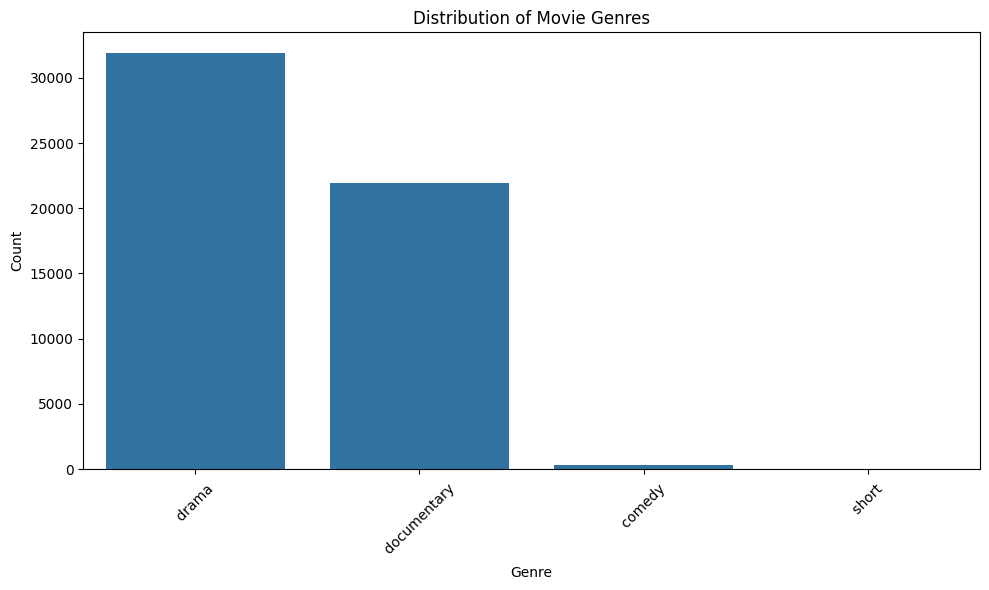

In [5]:
plt.figure(figsize=(10,6))
sns.countplot(data=data,x='Predicted_Genre',order=data['Predicted_Genre'].value_counts().index)
plt.title("Distribution of Movie Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
data['text']=data['Title'].fillna('')+" "+data['Description'].fillna('')


In [7]:
def clean_text(text):
    text=text.lower()
    text=re.sub(r'[^a-z\s]', '',text)
    tokens=text.split()
    tokens=[word for word in tokens if word not in stopwords.words('english')]
    porter=PorterStemmer()
    tokens=[porter.stem(word) for word in tokens]
    return " ".join(tokens)

In [14]:
from tqdm import tqdm
import swifter
tqdm.pandas()
data['clean_text']=data['text'].progress_apply(clean_text)
print("\nCleaned text sample:")
print(data['clean_text'].head())

100%|████████████████████████████████████████████████████████████████████████████| 54200/54200 [51:30<00:00, 17.54it/s]


Cleaned text sample:
0    edgar lunch lr brane love life car apart job e...
1    la guerra de pap spain march quico naughti chi...
2    beaten track one year life albin famili shephe...
3    meu amigo hindu father die hasnt spoken brothe...
4    er nu zhai known intern martial art superstar ...
Name: clean_text, dtype: object


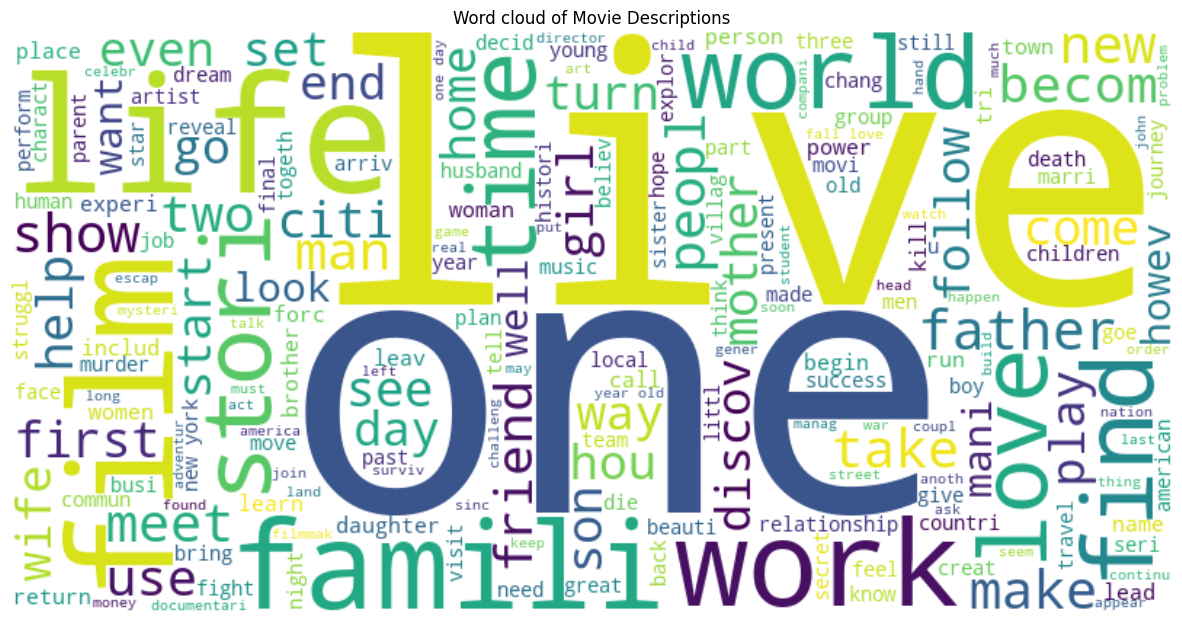

In [18]:
all_text=" ".join(data['clean_text'])
wordcloud=WordCloud(width=800,height=400,background_color='white').generate(all_text)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title("Word cloud of Movie Descriptions")
plt.show()

In [22]:
vectorizer=TfidfVectorizer(max_features=5000)
x=vectorizer.fit_transform(data['clean_text']).toarray()


In [23]:
le=LabelEncoder()
y=le.fit_transform(data['Predicted_Genre'])

In [26]:
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)
print("Training size:",X_train.shape)
print("Test size:",X_test.shape)

Training size: (43360, 5000)
Test size: (10840, 5000)


In [31]:
lr=LogisticRegression(max_iter=1000)
param_grid={'C':[0.1,1,10]}

In [32]:
grid_search=GridSearchCV(lr,param_grid,cv=5,scoring='accuracy',n_jobs=-1,verbose=1)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10]}, scoring='accuracy', verbose=1)

In [34]:
print("\nBest parameters found:",grid_search.best_params_)
print("Best cross-validation accuracy:{:.4f}".format(grid_search.best_score_))
best_model=grid_search.best_estimator_



Best parameters found: {'C': 1}
Best cross-validation accuracy:0.9346


In [38]:
y_pred=best_model.predict(X_test)
test_accuracy=accuracy_score(y_test,y_pred)
print("\nTest set accuracy: {:4f}". format(test_accuracy))
print("\nClassification Report:")
print(classification_report(y_test,y_pred,target_names=le.classes_))


Test set accuracy: 0.935148

Classification Report:
               precision    recall  f1-score   support

      comedy        1.00      0.35      0.52        66
 documentary        0.93      0.92      0.92      4392
       drama        0.94      0.95      0.95      6378
       short        0.00      0.00      0.00         4

     accuracy                           0.94     10840
    macro avg       0.72      0.55      0.60     10840
 weighted avg       0.93      0.94      0.93     10840



C:\Users\KASHISH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KASHISH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\KASHISH\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

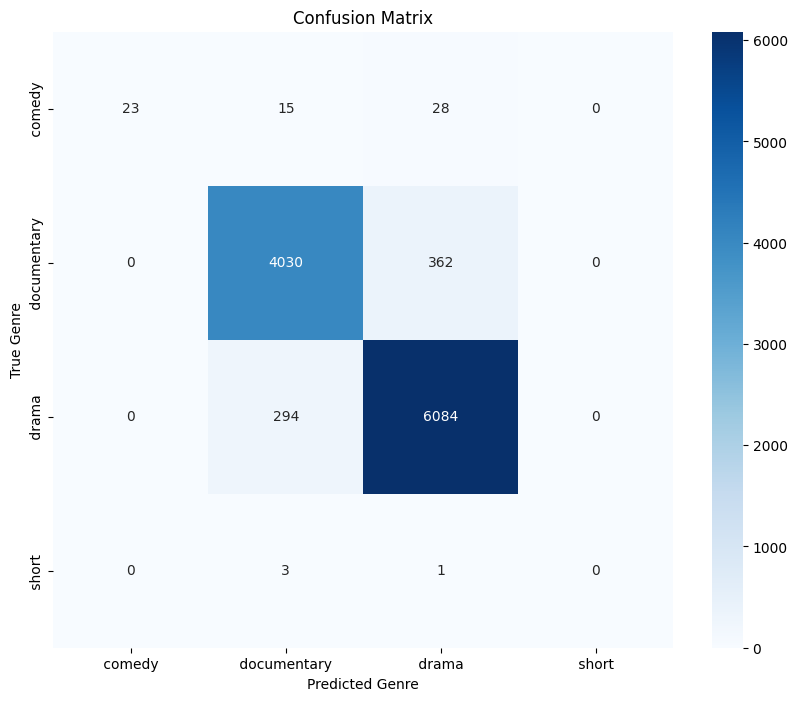

In [39]:
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=le.classes_,yticklabels=le.classes_)
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.title("Confusion Matrix")
plt.show()

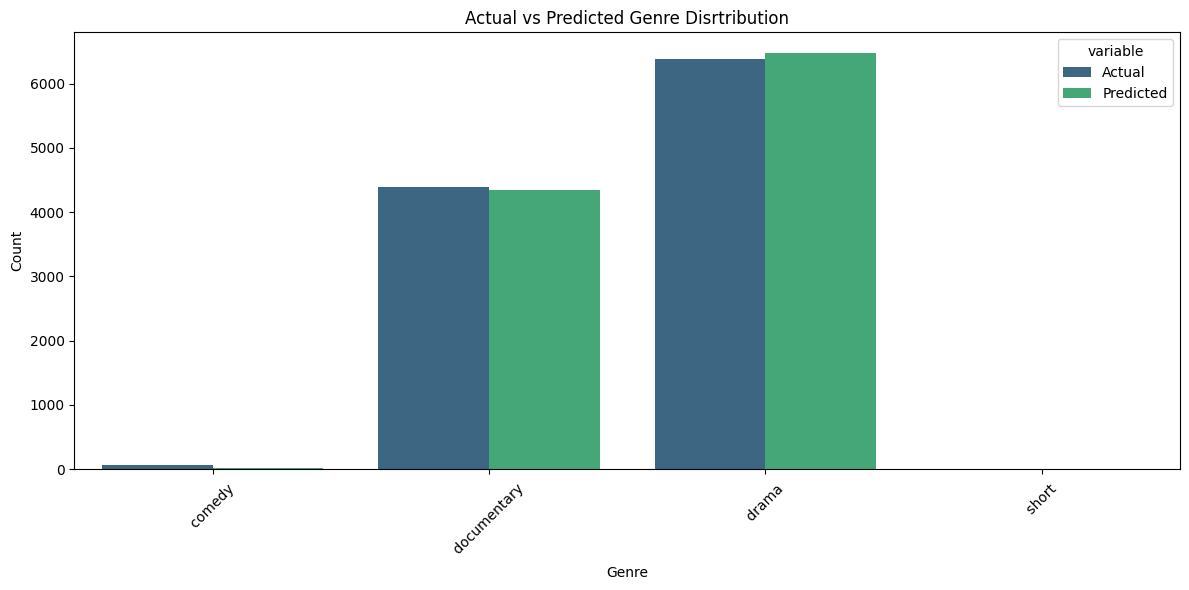

In [46]:
actual_genres=pd.Series(y_test).map(dict(enumerate(le.classes_)))
predicted_genres=pd.Series(y_pred).map(dict(enumerate(le.classes_)))
actual_counts=actual_genres.value_counts().sort_index()
predicted_counts=predicted_genres.value_counts().sort_index()
genre_data=pd.DataFrame({
    'Actual':actual_counts,
    'Predicted':predicted_counts
}).reset_index().rename(columns={'index':'Genre'})
plt.figure(figsize=(12,6))
sns.barplot(data=genre_data.melt(id_vars='Genre',value_vars=['Actual','Predicted']),x='Genre',y='value',hue='variable',palette='viridis')
plt.title("Actual vs Predicted Genre Disrtribution")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()